In [4]:
from ift6758.data import import_dataset
from ift6758.features import tidy_data as td
from ift6758.ressources import get_icerink
from IPython.display import display
import sys
import ipywidgets as widgets
import pandas as pd
import plotly as pl
import plotly.graph_objects as go
import plotly.express as px
from PIL import Image
import numpy as np

po_json = import_dataset(2018, "P", returnData=True)
po_tidy_json = td.extract_data_from_json(po_json)
po_df = pd.DataFrame(po_tidy_json)

def load_data(s_type="P", year=None):
    out_df = pd.DataFrame()
    if year == None :
        for year in [2016,2017,2018,2019,2020]:
            print(f"Loading {s_type} {year}")
            json_data = import_dataset(year, s_type, returnData=True)
            tidy_json = td.extract_data_from_json(json_data)
            df = td.tidy_data(tidy_json)
            df["year"] = year
            df["seasonType"] = s_type
            out_df = out_df.append(df)
    else:
        print(f"Loading {s_type} {year}")
        json_data = import_dataset(year, s_type, returnData=True)
        tidy_json = td.extract_data_from_json(json_data)
        df = td.tidy_data(tidy_json)
        df["year"] = year
        df["seasonType"] = s_type
        out_df = out_df.append(df)
    
    return out_df

def half_rink_fig():
    img = get_icerink()
    w, h = img.size
    half_img = img.crop([550, 0, w, h])
    fig = go.Figure()
    fig.add_layout_image(
        dict(
            source=half_img,
            xref="x",
            yref="y",
            x=0,
            y=43,
            sizex=100,
            sizey=86,
            sizing='stretch',
            opacity=0.2)
    )
    fig.update_xaxes(range=[0,100])
    fig.update_yaxes(range=[-43,43])
    fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False) 
    return fig

def rink_fig():
    img = get_icerink()
    fig = go.Figure()
    fig.add_layout_image(
        dict(
            source=img,
            xref="x",
            yref="y",
            x=-100,
            y=43,
            sizex=200,
            sizey=86,
            sizing='stretch',
            opacity=0.8)
    )
    fig.update_xaxes(range=[-100,100])
    fig.update_yaxes(range=[-43,43])
    fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False) 
    return fig

data_df = load_data("P")
#flipping coords to bring back shot data to positive half of rink
data_df.loc[(data_df["Coordinates.x"] < 0), "Coordinates.y"] = -data_df[data_df["Coordinates.x"] < 0]["Coordinates.y"].copy()
data_df.loc[(data_df["Coordinates.x"] < 0), "Coordinates.x"] = -data_df[data_df["Coordinates.x"] < 0]["Coordinates.x"].copy()

Loading P 2016
Loading P 2017
Loading P 2018
Loading P 2019
Loading P 2020


In [5]:
def get_playtime(data):
    games = data[["GamePk", "GameDuration"]].drop_duplicates()
    total_game_time = games["GameDuration"].sum()
    hours, remainder = divmod(total_game_time.total_seconds(), 3600)
    return hours + (remainder/3600) # total game time in hours as float.

def get_shot_rate_hist(data, x_bins, y_bins):
    x_coords_shot = data["Coordinates.x"].to_numpy()
    y_coords_shot = data["Coordinates.y"].to_numpy()
    game_time = get_playtime(data)
    H_shot, xedges, yedges = np.histogram2d(x_coords_shot, y_coords_shot, bins = [x_bins, y_bins], range=[[0, 100], [-43, 43]])
    return H_shot.T / game_time

binning_factor_x = 6
binning_factor_y = 10

x_bins = int(100 / binning_factor_x)
y_bins = int(86 / binning_factor_y)
data_df = data_df[~data_df["Coordinates.x"].isna()]

H_season = get_shot_rate_hist(data_df[data_df["year"] == 2016], x_bins, y_bins)

df_shark = data_df[(data_df["year"] == 2016) & (data_df["Team.id"] == 28)]
H_shark = get_shot_rate_hist(df_shark, x_bins, y_bins)

Montréal Canadiens
28.118081180811807
22.583333333333332



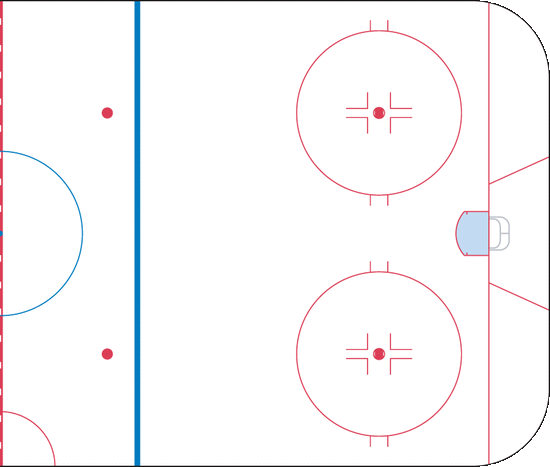

In [7]:
def build_menu_selection(data_df, x_bins, y_bins):
    button_list = []
    teams_dict = {}
    n_false = [False] * (len(data_df[["year", "Team.id"]].drop_duplicates())+1)
    v = True
    acc = 0
    H_dict = {}
    for season in [2016,2017,2018,2019,2020]:
        season_data = data_df[data_df["year"] == season]
        
        if season_data.empty:
            continue
        
        season_shot_data = season_data[["GamePk","GameDuration","EventTypeId", "Coordinates.x", "Coordinates.y", "Strength", "Team.id"]].copy()
        season_goal_data = season_shot_data[season_shot_data["EventTypeId"] == "GOAL"].copy()

        H_shot = get_shot_rate_hist(season_shot_data, x_bins, y_bins)
        # playtime = get_playtime(season_shot_data)
        

        x_coords = np.linspace(0,100, H_shot.shape[1])
        y_coords = np.linspace(-43,43, H_shot.shape[0])
                
        x_coords_shot = data_df["Coordinates.x"].to_numpy()
        y_coords_shot = data_df["Coordinates.y"].to_numpy()
    
        team_ids = season_data["Team.id"].drop_duplicates().to_list()
        
        H_ave = np.zeros((y_bins,x_bins))
        i = 0
        for team_id in team_ids:
            team_data = season_data[season_data["Team.id"] == team_id].copy()
            team_shot_data = team_data[["GamePk","GameDuration","EventTypeId", "Coordinates.x", "Coordinates.y", "Strength", "Team.id"]].copy()
            H_team = get_shot_rate_hist(team_shot_data, x_bins, y_bins)
            H_ave += H_team
            i += 1
        H_ave /= i
        
        H_dict[f'{season}'] = H_ave
        
        for team_id in team_ids:
            team_data = season_data[season_data["Team.id"] == team_id].copy()
            team_name = team_data["Team.name"].drop_duplicates().iloc[0]
            team_shot_data = team_data[["GamePk","GameDuration","EventTypeId", "Coordinates.x", "Coordinates.y", "Strength", "Team.id"]].copy()
            team_goal_data = team_shot_data[team_shot_data["EventTypeId"] == "GOAL"].copy()
            
            x_coords_shot = team_shot_data["Coordinates.x"].to_numpy()
            y_coords_shot = team_shot_data["Coordinates.y"].to_numpy()
            
            H_team = get_shot_rate_hist(team_shot_data, x_bins, y_bins)
            
            total_time_hours = get_playtime(team_data)
            if season == 2020 and team_id == 8:
                print(team_name)
                print(H_team.sum())
                print(total_time_hours)

            x_coords = np.linspace(0,100, H_team.shape[1])
            y_coords = np.linspace(-43,43, H_team.shape[0])
            
            contour_plot_settings = dict(
                z=H_team - H_ave,
                x=x_coords,
                y=y_coords,
                colorscale='RdBu',
                reversescale=True,
                visible=v,
                zmin=-1,
                zmax=1,
                line_smoothing=0.9,
                colorbar=dict(
                    title='Excess Shots per hour',
                    titleside='right',
                    titlefont=dict(
                        size=14,
                        family='Arial, sans-serif')
                    )
            )

            v=False
            teams_dict[f"{season}-{team_id}"] = contour_plot_settings
            teams_args = n_false.copy()
            teams_args[acc] = True
            acc += 1
            button_list.append({'method':'update', 'label':f'{season} - {team_name} - {team_id}', 'args':[{'visible':teams_args}]})
            
        
    return button_list, teams_dict

fig = half_rink_fig()

buttons, settings = build_menu_selection(data_df, x_bins, y_bins)

x_coords = np.linspace(0,100, H_season.shape[1])
y_coords = np.linspace(-43,43, H_season.shape[0])
                


# contour_plot_settings = dict(
#     z=H_season,
#     x=x_coords,
#     y=y_coords,
#     colorscale='RdBu',
#     reversescale=True,
#     visible=True,
#     # zmin=-1,
#     # zmax=1,
#     # zmax=5,
#     line_smoothing=0.67,
#     colorbar=dict(
#         title='Excess Shots per hour',
#         titleside='right',
#         titlefont=dict(
#             size=14,
#             family='Arial, sans-serif')
#         )
# )

# fig.add_trace(go.Contour(**contour_plot_settings))

for s in settings.values():
    fig.add_trace(go.Contour(**s))

# construct menus
updatemenus = [{'buttons': buttons,
                'direction': 'down',
                'showactive': True,}]



# # update layout with buttons, and show the figure
fig.update_layout(updatemenus=updatemenus)
fig.update_layout(width=1200,height=800,title="Offence Heatmap",)

fig.update_xaxes(
        tickangle = 90,
        title_text = "Distance from center line",
        title_font = {"size": 20},
        title_standoff = 25)

fig.update_yaxes(
        title_text = "Distance from centre of rink",
        title_standoff = 25)

fig.show()
fig.write_html("./file.html")